In [ ]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip drive/MyDrive/data/GAN/patches-normal.zip > /dev/null

In [ ]:
path = glob.glob("./patches-normal/*.jpg")

# images =[]
# for file in tqdm(path):
#     img = plt.imread(file)
#     # img = cv2.resize(img, (64,64))
#     # plt.imshow(img)
#     img = img / 255. * 2. - 1.
#     images.append(img)
# X_train = np.asarray(images)

np.random.seed(42)
tf.random.set_seed(42)
batch_size = 32
codings_size = 400

def get_image():
   for file in path:
     img = plt.imread(file)
     img = cv2.resize(img , (128,128))
     img = img / 255. * 2. - 1.
     yield img # Your supposed to yield in a loop

dataset = tf.data.Dataset.from_generator(get_image, output_types=(tf.float32))
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

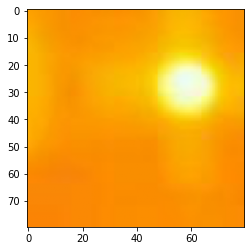

In [ ]:
plt.imshow(np.squeeze((X_train[0] + 1.) / 2.))

In [ ]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        image = (image + 1.) / 2.
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image)
        plt.axis("off")

In [ ]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=500):    
    generator, discriminator = gan.layers
    for i, epoch in enumerate(range(n_epochs)):
      disc_metrics=[]
      gan_metrics=[]
      print("Epoch {}/{}".format(epoch + 1, n_epochs))
      for j,  X_batch in enumerate(tqdm(dataset)):
          X_batch = tf.cast(X_batch, tf.float32)
          # phase 1 - training the discriminator
          noise = tf.random.normal(shape=[batch_size, codings_size])
          generated_images = generator(noise)
          X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
          y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
          discriminator.trainable = True
          logs= discriminator.train_on_batch(X_fake_and_real, y1)
          disc_metrics.append(logs)
          # phase 2 - training the generator
          noise = tf.random.normal(shape=[batch_size, codings_size])
          y2 = tf.constant([[1.]] * batch_size)
          discriminator.trainable = False
          logs = gan.train_on_batch(noise, y2)
          gan_metrics.append(logs)
      disc_metrics = np.mean(disc_metrics, axis=0)
      gan_metrics = np.mean(gan_metrics, axis=0)
      print("Dis: loss= {:.4f}, mae= {:.4f}, acc= {:.4f}\nGAN: loss= {:.4f}, mae= {:.4f}, acc= {:.4f}".format(
          disc_metrics[0], disc_metrics[1], disc_metrics[2], gan_metrics[0], gan_metrics[1], gan_metrics[2])
      )
      if i % 5 == 0:
        gan.save("./drive/MyDrive/models/GAN/7-GAN/7_gan_{}.hdf5".format(i))
        plot_multiple_images(generated_images, 8)
        plt.show()

In [ ]:
# metrics = []
# for i, X_batch in enumerate(dataset):
#   if i > 1:
#     break
#   X_batch = tf.cast(X_batch, tf.float32)
#   # phase 1 - training the discriminator
#   noise = tf.random.normal(shape=[batch_size, codings_size])
#   generated_images = generator(noise)
#   X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
#   y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
#   discriminator.trainable = True
#   logs = discriminator.train_on_batch(X_fake_and_real, y1)
#   metrics.append(logs)

In [ ]:
generator = keras.models.Sequential([
    keras.layers.Dense(8 * 8 * 256, input_shape=[codings_size]),
    keras.layers.Reshape([8, 8, 256]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(128, kernel_size=5, strides=2, padding="same", activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="same", activation="selu"),
    keras.layers.BatchNormalization(),    
    keras.layers.Conv2DTranspose(32, kernel_size=5, strides=2, padding="same", activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(3, kernel_size=5, strides=2, padding="same", activation="tanh")
])
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=5, strides=2, padding="same", activation=keras.layers.LeakyReLU(0.2), input_shape=[128, 128, 3]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="same", activation=keras.layers.LeakyReLU(0.2)), 
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="same", activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(256, kernel_size=5, strides=2, padding="same", activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

In [ ]:
generator.summary()
discriminator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             6569984   
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 256)        1024      
 ormalization)                                                   
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      819328    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 128)      512       
 hNormalization)                                                 
                                                        

In [ ]:
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002), metrics=['mae', 'accuracy'])
discriminator.trainable = False
gan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002), metrics=['mae', 'accuracy'])

In [ ]:
train_gan(gan, dataset, batch_size, codings_size)